In [18]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
import sklearn.svm
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import joblib
import functools
import itertools
import collections
import local_models.loggin
import local_models.TLS_models
import local_models.utils
import local_models.algorithms
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR

logger = logging.getLogger(__name__)

np.random.seed(1)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
BANDWIDTH = 0.35
C = 60.
n = 200
noise=.06
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=noise)

In [4]:
RUN = 1
project_dir = "../data/local_rms_moons_{:03d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

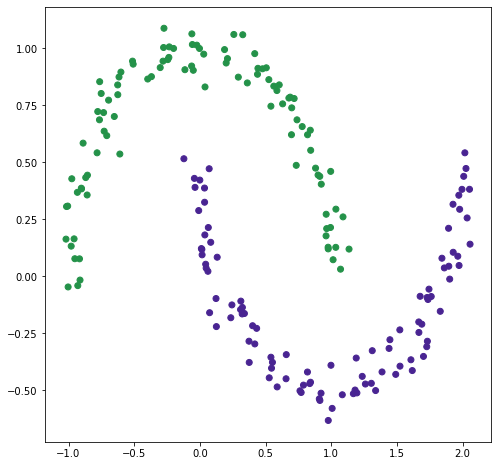

In [5]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.show()

In [6]:
kernel = local_models.local_models.GaussianKernel(bandwidth=BANDWIDTH)
model = local_models.TLS_models.Mean()
linear_models = local_models.local_models.LocalModels(model)
linear_models.fit(noisy_moons)

In [7]:
RANGE_PCT = 0.1
data = noisy_moons
min_data, max_data = np.min(data, axis=0), np.max(data, axis=0)
data_range = max_data - min_data
how_much_to_include_outside_range = RANGE_PCT*data_range
data_ranges = np.stack((min_data - how_much_to_include_outside_range, max_data + how_much_to_include_outside_range)).T
data_step = ((data_ranges[:,1] - data_ranges[:,0])/20)
grid_limits = tuple(map(lambda i: slice(data_ranges[i][0], data_ranges[i][1], data_step[i]), range(data_ranges.shape[0])))
g = np.mgrid[grid_limits]
xx = np.vstack(map(np.ravel, g)).T
g_like_shape = [-1] + list(g.shape[1:])

In [8]:
np.sum(g.transpose(1,2,0)**2,axis=-1)

array([[2.40707854e+00, 2.25170630e+00, 2.11763438e+00, 2.00486276e+00,
        1.91339145e+00, 1.84322046e+00, 1.79434977e+00, 1.76677939e+00,
        1.76050931e+00, 1.77553955e+00, 1.81187010e+00, 1.86950095e+00,
        1.94843212e+00, 2.04866359e+00, 2.17019537e+00, 2.31302746e+00,
        2.47715986e+00, 2.66259257e+00, 2.86932559e+00, 3.09735891e+00],
       [1.95153948e+00, 1.79616724e+00, 1.66209532e+00, 1.54932370e+00,
        1.45785239e+00, 1.38768139e+00, 1.33881070e+00, 1.31124032e+00,
        1.30497025e+00, 1.32000049e+00, 1.35633103e+00, 1.41396189e+00,
        1.49289305e+00, 1.59312453e+00, 1.71465631e+00, 1.85748840e+00,
        2.02162080e+00, 2.20705351e+00, 2.41378652e+00, 2.64181985e+00],
       [1.56409296e+00, 1.40872073e+00, 1.27464880e+00, 1.16187718e+00,
        1.07040588e+00, 1.00023488e+00, 9.51364188e-01, 9.23793807e-01,
        9.17523735e-01, 9.32553973e-01, 9.68884519e-01, 1.02651537e+00,
        1.10544654e+00, 1.20567801e+00, 1.32720979e+00, 1.4700

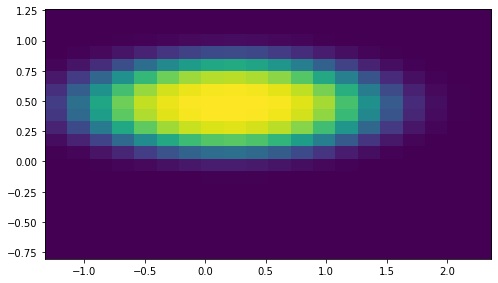

In [9]:
plt.imshow(kernel(np.sum(g.transpose(1,2,0)**2,axis=-1)), extent=data_ranges.reshape(-1))

In [10]:
xx_linear_params, the_models = linear_models.transform(xx,r=kernel.support_radius(),weighted=True,kernel=kernel, return_models=True)
xx_linear_params.shape

(400, 2)

In [11]:
projected_xx = linear_models.predict(xx, r=kernel.support_radius(), weighted=True, kernel=kernel)

In [12]:
projected_xx

array([[-9.55409434e-01,  4.34707849e-02],
       [-9.55271179e-01,  5.58868193e-02],
       [-9.54901904e-01,  7.03848921e-02],
       [-9.54175829e-01,  8.72802275e-02],
       [-9.52921066e-01,  1.06889667e-01],
       [-9.50912182e-01,  1.29509279e-01],
       [-9.47866193e-01,  1.55388219e-01],
       [-9.43445223e-01,  1.84702830e-01],
       [-9.37269740e-01,  2.17535095e-01],
       [-9.28946400e-01,  2.53856696e-01],
       [-9.18113505e-01,  2.93514288e-01],
       [-9.04504011e-01,  3.36206833e-01],
       [-8.88019582e-01,  3.81448393e-01],
       [-8.68799360e-01,  4.28524009e-01],
       [-8.47257358e-01,  4.76467144e-01],
       [-8.24061380e-01,  5.24097805e-01],
       [-8.00042441e-01,  5.70143248e-01],
       [-7.76054198e-01,  6.13419742e-01],
       [-7.52828530e-01,  6.53013421e-01],
       [-7.30875637e-01,  6.88393648e-01],
       [-9.47123104e-01,  4.33832828e-02],
       [-9.47243939e-01,  5.62437131e-02],
       [-9.46964131e-01,  7.13913583e-02],
       [-9.

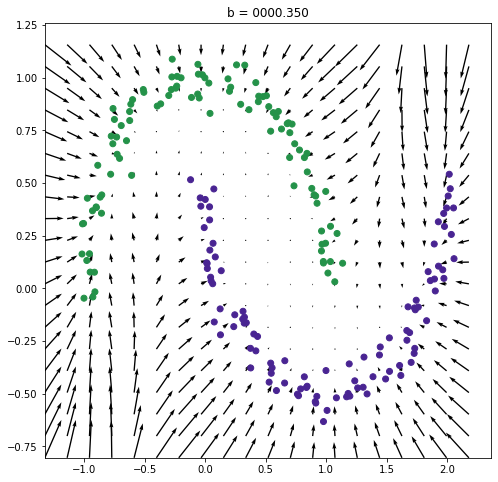

In [13]:
changes = projected_xx - xx
#pts = np.array([[1.8, 0.1]])
pts = xx
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=10.)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.title("b = {:08.03f}".format(BANDWIDTH))

span = np.linspace(0.05,0.05,10)
pts_params = linear_models.transform(pts, r=kernel.support_radius(), weighted=True, kernel=kernel)
#for i in range(pts.shape[0]):
#    x,y = pts[i]
#    plt.plot(span + x, (1-pts_params[i,0]*(span+x))/pts_params[i,1])
plt.savefig(os.path.join(project_dir, "b_{:08.03f}.png".format(BANDWIDTH)))
plt.show()

In [14]:
def linear_reject_pointwise_bases(x, bases, mean=0):
    x = x - mean #mean center everything
    projection = local_models.utils.linear_project_pointwise_bases(x, bases)
    rejection = x - projection
    rejection = rejection + mean #re-add the mean in
    return rejection

def scms(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None):
    #all_failures = []
    print(X.shape)
    if failure_delta is None:
        failure_delta = np.average(lm.index.query(X, k=2)[0][:,1])*1e4
        #print("default failure delta: {}".format(failure_delta))
    for i in range(iters):
        #print("scms iteration {:04d}".format(i))
        X = np.copy(X)
        Xrange = np.arange(X.shape[0])
        params = lm.transform(X, r=kernel.support_radius(), weighted=True,
            kernel=kernel)
        normalized_params = params/np.sqrt(np.sum(params[:,:X.shape[1]]**2,axis=-1,keepdims=True))
        normals = normalized_params[:,:X.shape[1]]
        intercepts = normalized_params[:,X.shape[1]]
        biggest_normal_component = np.argmax(normals, axis=1)
        biggest_normal_component_indices = np.stack((Xrange, biggest_normal_component))
        biggest_normal_component_indices = tuple(map(tuple, biggest_normal_component_indices))
        
        plane_pt_component = -intercepts/normalized_params[biggest_normal_component_indices]
        plane_pts = np.zeros(normals.shape)
        plane_pts[biggest_normal_component_indices] = plane_pt_component
        
        normals = normals.reshape(X.shape[0], 1, X.shape[1])
        new_X = linear_reject_pointwise_bases(X, normals, plane_pts)
        failures = np.sqrt(np.sum((new_X-X)**2, axis=1)) > failure_delta
        successes = np.logical_not(failures)
        X[successes] = new_X[successes]
        if constraint_space is not None:
            X[successes] = local_models.utils.linear_project_pointwise_bases(X[successes], constraint_space[0][successes], constraint_space[1][successes])

        if return_params:
            yield X, successes, normals
        else:
            yield X, successes

def exhaust(gen):
    def exhauster(*args, **kwargs):
        for _ in gen(*args, **kwargs): pass
        return _
    return exhauster

import tempfile
import time
def scms_parallel_sharedmem(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    with tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_X_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint0_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint1_ramspace:
        shared_X = np.memmap(shared_X_ramspace, dtype=X.dtype,
                   shape=X.shape, mode='w+')
        shared_X[:] = X[:]
        if constraint_space is not None:
            shared_constraint_space0 = np.memmap(shared_constraint0_ramspace, dtype=constraint_space[0].dtype,
                   shape=constraint_space[0].shape, mode='w+')
            shared_constraint_space1 = np.memmap(shared_constraint1_ramspace, dtype=constraint_space[1].dtype,
                   shape=constraint_space[1].shape, mode='w+')
            shared_constraint_space0[:] = constraint_space[0][:]
            shared_constraint_space1[:] = constraint_space[1][:]
            constraint_space = (shared_constraint_space0, shared_constraint_space1)
        parallel_sols = joblib.Parallel(n_jobs=12)(joblib.delayed(exhaust(scms))(
            shared_X[slice(*batch)], lm, kernel, iters, 
            None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
            return_params, failure_delta)
            for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res
    
def scms_parallel(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    parallel_sols = joblib.Parallel(n_jobs=12)(joblib.delayed(exhaust(scms))(
        X[slice(*batch)], lm, kernel, iters, 
        None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
        return_params, failure_delta)
        for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res

import traceback
import collections
def orthogonal_project_scms(X, lm, kernel, scms_iters=30, newtons_iters=30, alpha=1e-2, return_everything=False, parallel=False, sharedmem=True):
    #1. do scms to get *a* point on the surface, y
    #2. get the tangent plane at y
    scms_method = scms_parallel_sharedmem if (parallel and sharedmem) else (scms_parallel if parallel else scms)
    
    if return_everything:
        everything = collections.defaultdict(list)
    shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True)
    for y, successes, normals in shifter:
        if return_everything:
            everything[0].append((y, successes, normals))
    X = X[successes]
    y = y[successes]
    normals = normals[successes]
    #3. do scms while projecting along some convex combo of the line passing thru x and y, and 
    #   the line passing through x and along the normal vector to the tangent plane in 2 to get y'
    #4. y <- y'
    #5. GOTO 2
    for i in range(newtons_iters):
        print("newtons method iteration: {:04d}".format(i))
        print(X.shape, y.shape, normals.shape)
        try:
            Xy = y-X
            normalized_Xy = (Xy)/np.sqrt(np.sum(Xy**2,axis=1,keepdims=True))
            normalized_Xy = np.expand_dims(normalized_Xy, 1)
            #print("shapes", normalized_Xy.shape, normals.shape)
            surface_normal_aligned_Xy = normalized_Xy * np.sign(np.sum(normalized_Xy*normals, axis=-1, keepdims=True))
            constraint_vec = surface_normal_aligned_Xy*(1-alpha) + normals*alpha
            constraint_vec = constraint_vec/np.sqrt(np.sum(constraint_vec**2, axis=-1, keepdims=True))
            print("constraint shape", constraint_vec.shape)
            shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True,constraint_space=(constraint_vec, X))
            for y, successes, normals in shifter:
                if return_everything:
                    everything[i+1].append((y, successes, normals))
            X = X[successes]
            y = y[successes]
            normals = normals[successes]
        except:
            traceback.print_exc()
            break
    if return_everything:
        return everything
    return X, y, normals  

In [20]:
start = time.time()
test = exhaust(local_models.algorithms.mean_shift)(linear_models, noisy_moons, kernel=kernel)
stop = time.time()
print((stop-start)/60)

0.061493138472239174


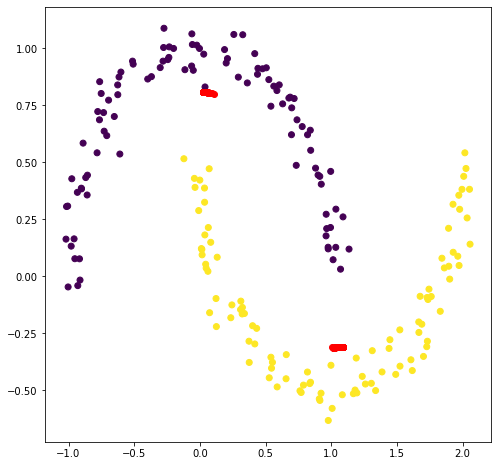

In [23]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=c)
plt.scatter(test[:,0], test[:,1], c='r')

In [209]:
class RMean(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    def __init__(self, n=1):
        self.n = n
    def fit(self, X, y=None, sample_weight=None):
        self.coef_=np.array(())
        if sample_weight is not None:
            randos = np.random.choice(X.shape[0], size=self.n, p=sample_weight/np.sum(sample_weight))
            self.intercept_ = np.average(X[randos], axis=0)
        else:
            self.intercept_ = np.average(X, axis=0)
        return self
    def predict(self, X):
        return np.repeat(self.intercept_.reshape((1,-1)), X.shape[0], axis=0)
    #def get_params(self, *args, **kwargs):
    #    return dict()
    #def set_params(self, params, *args, **kwargs):
    #    pass
    def project(self, x):
        return self.intercept_ - x

In [210]:
rmodel.n

100000

In [211]:
noisy_moons[np.array([1,1])]

array([[0.32617603, 1.05924662],
       [0.32617603, 1.05924662]])

In [212]:
rmodel = RMean(5)
rmodels = local_models.local_models.LocalModels(rmodel)
rmodels.fit(noisy_moons)

In [213]:
rm_xx = rmodels.predict(xx, r=kernel.support_radius(), kernel=kernel, weighted=True)

In [214]:
xx.shape

(400, 2)

In [215]:
rm_xx.shape

(400, 2)

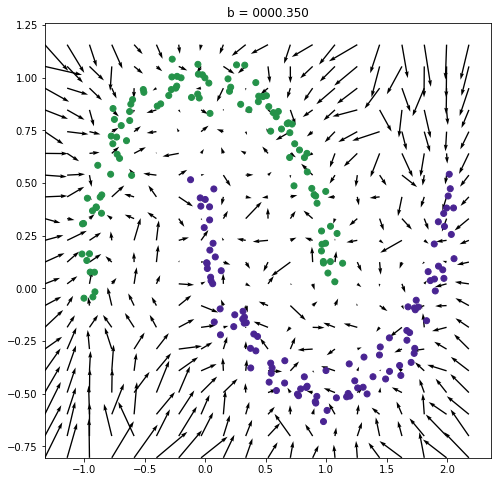

In [216]:
changes = rm_xx - xx
#pts = np.array([[1.8, 0.1]])
pts = xx
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=10.)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.title("b = {:08.03f}".format(BANDWIDTH))

span = np.linspace(0.05,0.05,10)
pts_params = linear_models.transform(pts, r=kernel.support_radius(), weighted=True, kernel=kernel)
#for i in range(pts.shape[0]):
#    x,y = pts[i]
#    plt.plot(span + x, (1-pts_params[i,0]*(span+x))/pts_params[i,1])
plt.savefig(os.path.join(project_dir, "b_{:08.03f}.png".format(BANDWIDTH)))
plt.show()

In [217]:
start = time.time()
shifter = local_models.algorithms.mean_shift(rmodels, xx, kernel=kernel, iterations=500)
shifts = list(shifter)
stop = time.time()
print((stop-start)/60)

0.8719417850176493


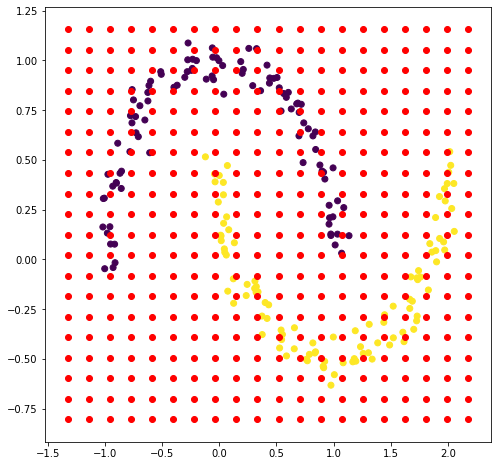

In [218]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=c)
plt.scatter(shifts[0][:,0], shifts[0][:,1], c='r')

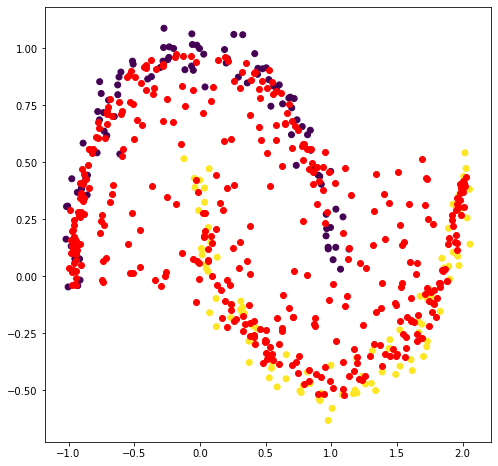

In [219]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=c)
plt.scatter(shifts[1][:,0], shifts[1][:,1], c='r')

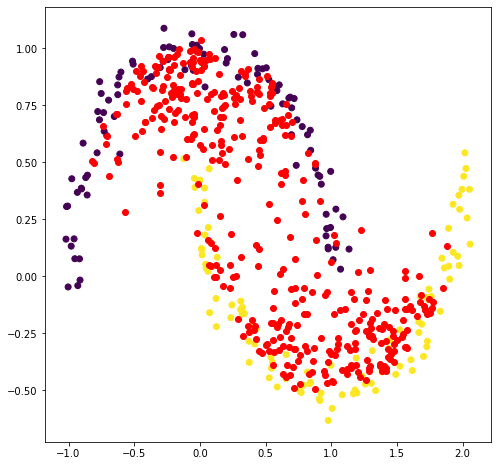

In [220]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=c)
plt.scatter(shifts[-1][:,0], shifts[-1][:,1], c='r')

In [270]:
import scipy.spatial

In [271]:
trans_mat = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(noisy_moons))

In [272]:
trans_mat

array([[0.        , 0.61789881, 0.75791641, ..., 0.49148623, 1.77799596,
        0.64878524],
       [0.61789881, 0.        , 0.21187265, ..., 1.10790194, 1.60457155,
        0.21424468],
       [0.75791641, 0.21187265, 0.        , ..., 1.23251871, 1.42182152,
        0.13105892],
       ...,
       [0.49148623, 1.10790194, 1.23251871, ..., 0.        , 2.00148045,
        1.11325226],
       [1.77799596, 1.60457155, 1.42182152, ..., 2.00148045, 0.        ,
        1.39238229],
       [0.64878524, 0.21424468, 0.13105892, ..., 1.11325226, 1.39238229,
        0.        ]])

In [273]:
trans_mat.shape

(200, 200)

In [274]:
mc_mat = kernel(trans_mat)

In [275]:
mc_mat = mc_mat/np.sum(mc_mat, axis=0, keepdims=True)
mc_mat

array([[3.29881623e-02, 8.05111786e-03, 3.26590169e-03, ...,
        1.43920226e-02, 8.52454195e-08, 5.69588286e-03],
       [6.94335975e-03, 3.82511626e-02, 2.83592510e-02, ...,
        2.57339637e-04, 9.34396494e-07, 2.63230140e-02],
       [3.16295531e-03, 3.18471975e-02, 3.40618456e-02, ...,
        7.82544306e-05, 8.93153351e-06, 2.95973794e-02],
       ...,
       [1.23073278e-02, 2.55173244e-04, 6.90972754e-05, ...,
        3.85759108e-02, 2.71275728e-09, 2.01755539e-04],
       [8.21476285e-08, 1.04409904e-06, 8.88709992e-06, ...,
        3.05698270e-09, 3.42321475e-02, 1.16158637e-05],
       [5.91859235e-03, 3.17160805e-02, 3.17556270e-02, ...,
        2.45155089e-04, 1.25252069e-05, 3.17468576e-02]])

In [276]:
eigv, eig = np.linalg.eig(mc_mat)

In [277]:
eigv

array([1.00000000e+00, 9.49808027e-01, 8.64108536e-01, 8.02471509e-01,
       6.94931846e-01, 6.36175094e-01, 4.84954383e-01, 4.66072397e-01,
       3.52894893e-01, 3.13385812e-01, 1.90683141e-01, 1.87647356e-01,
       1.21875993e-01, 1.11120754e-01, 6.70597612e-02, 6.43938529e-02,
       3.50538508e-02, 3.30199628e-02, 2.82393381e-02, 2.59928270e-02,
       2.13806182e-02, 1.68815552e-02, 1.40935000e-02, 1.27734295e-02,
       1.05916399e-02, 1.01135163e-02, 9.36979068e-03, 8.09698087e-03,
       6.04679195e-03, 5.65032285e-03, 5.06949706e-03, 4.01184836e-03,
       3.38490861e-03, 2.87999065e-03, 2.47679746e-03, 2.18254049e-03,
       1.63512579e-03, 1.58988062e-03, 1.05151366e-03, 9.50600856e-04,
       8.08428923e-04, 7.42967753e-04, 5.76532233e-04, 5.11483627e-04,
       4.38254184e-04, 3.54796039e-04, 3.08001778e-04, 2.42398048e-04,
       1.94827886e-04, 1.93368443e-04, 1.51871693e-04, 1.30702057e-04,
       1.24939683e-04, 1.12715801e-04, 9.34316902e-05, 7.57701507e-05,
      

In [278]:
eig[:,0]

array([0.07820912, 0.06744828, 0.07574384, 0.07142729, 0.06818294,
       0.03856912, 0.04666359, 0.06830877, 0.07713355, 0.06803373,
       0.07972068, 0.07215478, 0.06976502, 0.06182876, 0.07075355,
       0.07448174, 0.0718214 , 0.07822593, 0.07496463, 0.0667561 ,
       0.07594096, 0.07130661, 0.07598426, 0.04359937, 0.07517552,
       0.08108104, 0.07447393, 0.07454679, 0.04894585, 0.07764616,
       0.07875933, 0.07967356, 0.04634746, 0.07422451, 0.06978999,
       0.0334078 , 0.07564796, 0.06295879, 0.07069649, 0.07673271,
       0.07193147, 0.07024149, 0.05443063, 0.07073869, 0.0760822 ,
       0.07025158, 0.06873752, 0.07260957, 0.06384926, 0.07595912,
       0.03511068, 0.06360336, 0.06341254, 0.0821793 , 0.07699414,
       0.07449068, 0.07529517, 0.07209495, 0.03344051, 0.06915167,
       0.07351422, 0.07212184, 0.06863433, 0.06891523, 0.07595612,
       0.07179991, 0.07349762, 0.07304453, 0.07617304, 0.07208577,
       0.08186045, 0.06539439, 0.06874988, 0.07569016, 0.07219

In [279]:
np.argmax(eig[:,0])

118

In [280]:
biggest = np.argsort(eig[:,0])[-6:]

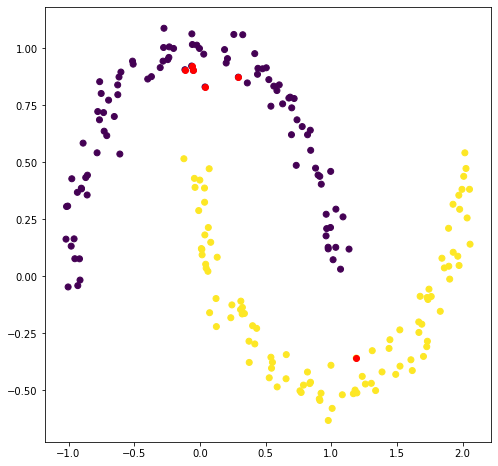

In [281]:
plt.scatter(noisy_moons[:,0],noisy_moons[:,1],c=c)
plt.scatter(noisy_moons[biggest][:,0],noisy_moons[biggest][:,1],c='r')

In [19]:
start = time.time()
test = orthogonal_project_scms(noisy_moons, linear_models, kernel, return_everything=True, parallel=True, alpha=0.3)
stop = time.time()
print((stop-start)/60)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [43]:
project_dir

'../data/local_svm_moons_015'

In [44]:
scmsnewtondir = os.path.join(project_dir, "scms_orthogonal")
os.makedirs(scmsnewtondir, exist_ok=1)

In [45]:
print(noisy_moons.shape)

(200, 2)


In [46]:
data_ranges[1]

array([-0.80437527,  1.25961644])

In [ ]:
X = noisy_moons
targets = c
data_range_1_avg = np.average(data_ranges[1])
data_range_0_rng = np.diff(data_ranges[0])
data_ranges[1] = np.concatenate([data_range_1_avg - data_range_0_rng/2, data_range_1_avg + data_range_0_rng/2])
for newton in test:
    print("plting newton {}".format(newton))
    for i in range(len(test[newton])):
        y, successes, normals = test[newton][i]
        print(list(map(lambda z: z.shape, (X, y, successes, normals))))
        fig = plt.figure()
        plt.scatter(y[:,0], y[:,1], s=2, c='r')
        for j in range(X.shape[0]):
            plt.plot(np.stack((X[j,0],y[j,0])), np.stack((X[j,1],y[j,1])), c='k')
        plt.scatter(X[:,0], X[:,1],c=cmap(targets))
        plt.xlim(*data_ranges[0])
        plt.ylim(*data_ranges[1])
        plt.title("iteration: {:05d}.{:05d}".format(newton,i))
        plt.savefig(os.path.join(scmsnewtondir, "svc_moons_{:05d}.png".format(newton*len(test[0]) + i)))
        plt.close(fig)
    X = X[successes]
    targets = targets[successes]

plting newton 0
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2

In [ ]:
normals

In [50]:
_, last_models = linear_models.transform(test[30][-1][0], kernel=kernel, weighted=True, r=kernel.support_radius(), return_models=True)

In [51]:
len(last_models)

200

In [53]:
train_preds = np.zeros((noisy_moons.shape[0],))
for i in range(noisy_moons.shape[0]):
    train_preds[i] = last_models[i].predict(noisy_moons[i:i+1])

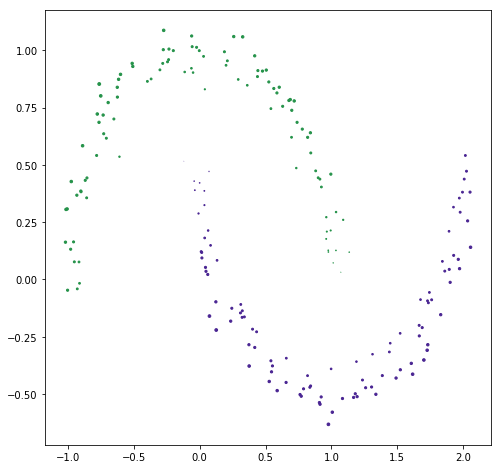

In [66]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=cmap(train_preds), s=20*np.sum((noisy_moons-test[30][-1][0])**2, axis=-1))

In [158]:
platt_regularizer = sklearn.linear_model.LogisticRegression(C=3e-1)

In [159]:
train_preds.shape

(200,)

In [160]:
(np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)).reshape(-1,1)

array([[-0.43568623],
       [-0.55190109],
       [-0.48930334],
       [ 0.17146981],
       [ 0.39282285],
       [ 0.43090036],
       [-0.5217878 ],
       [-0.13270435],
       [-0.48141331],
       [ 0.58087994],
       [ 0.37469295],
       [-0.44116361],
       [-0.24518847],
       [-0.47956607],
       [ 0.38094323],
       [ 0.46329055],
       [ 0.52000846],
       [-0.44806797],
       [ 0.47427409],
       [-0.56895866],
       [-0.45215553],
       [-0.41166122],
       [-0.44574649],
       [-0.43883313],
       [-0.51212815],
       [ 0.34588415],
       [-0.50926836],
       [-0.51448106],
       [ 0.39785263],
       [-0.46436564],
       [-0.4057071 ],
       [ 0.39141573],
       [ 0.41555068],
       [ 0.4311006 ],
       [ 0.52608946],
       [-0.48801541],
       [ 0.46527945],
       [-0.63552711],
       [-0.54395016],
       [ 0.44222717],
       [ 0.33597131],
       [ 0.27784953],
       [ 0.55575945],
       [-0.40782551],
       [-0.46199231],
       [-0

In [161]:
platt_regularizer.fit((np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)).reshape(-1,1), c)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [162]:
np.sum((noisy_moons-test[30][-1][0])**2, axis=1).shape

(200,)

In [163]:
probas = platt_regularizer.predict_proba((np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)).reshape(-1,1))

In [164]:
probas

array([[0.84518182, 0.15481818],
       [0.89532143, 0.10467857],
       [0.87039394, 0.12960606],
       [0.34334913, 0.65665087],
       [0.18189119, 0.81810881],
       [0.16101483, 0.83898517],
       [0.88390572, 0.11609428],
       [0.62872501, 0.37127499],
       [0.86691625, 0.13308375],
       [0.09707705, 0.90292295],
       [0.19254722, 0.80745278],
       [0.84793061, 0.15206939],
       [0.72338712, 0.27661288],
       [0.86609072, 0.13390928],
       [0.18882079, 0.81117921],
       [0.14481834, 0.85518166],
       [0.11973316, 0.88026684],
       [0.8513383 , 0.1486617 ],
       [0.13964184, 0.86035816],
       [0.90133877, 0.09866123],
       [0.85332589, 0.14667411],
       [0.83264379, 0.16735621],
       [0.85019961, 0.14980039],
       [0.84676599, 0.15323401],
       [0.88002093, 0.11997907],
       [0.21044547, 0.78955453],
       [0.87884947, 0.12115053],
       [0.88097741, 0.11902259],
       [0.1790174 , 0.8209826 ],
       [0.85913224, 0.14086776],
       [0.

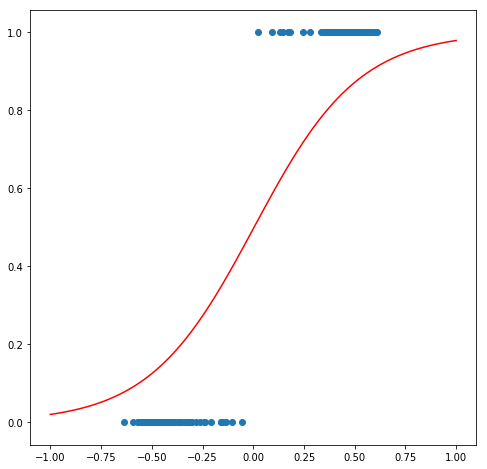

In [165]:
plt.scatter((np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)), c)
plt.plot(np.linspace(-1,1,100), platt_regularizer.predict_proba(np.linspace(-1,1,100).reshape(-1,1))[:,1], c='r')

In [166]:
list(map(tuple, np.stack((np.arange(c.shape[0]), train_preds.astype(int)))))

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [167]:
probas[list(map(tuple, np.stack((np.arange(c.shape[0]), train_preds.astype(int)))))].shape

(200,)

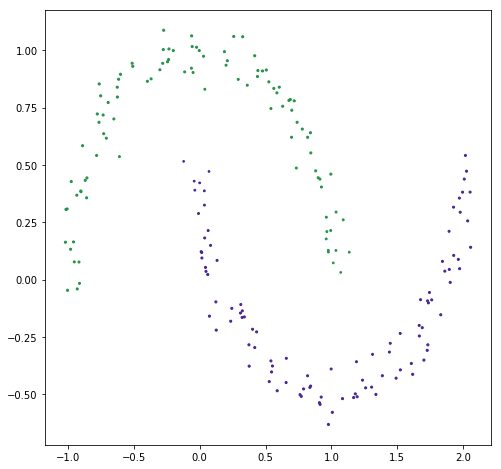

In [168]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=cmap(train_preds), s=5*probas[list(map(tuple, np.stack((np.arange(c.shape[0]), train_preds.astype(int)))))])